In [1]:
# LSTM Energy Consumption Prediction Model for EMS
# Based on time-series data with 10-minute intervals
# Includes 3-day prediction for all three zones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math
from datetime import datetime, timedelta


In [2]:
# 1. DATA LOADING AND PREPROCESSING
# Let's assume your data is uploaded to Colab
# If it's in CSV format, you can read it with:

# Upload your CSV file to Colab and read it
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your CSV file

Saving powerconsumption.csv to powerconsumption.csv


In [3]:
# Read the CSV file
file_name = list(uploaded.keys())[0]  # Get the name of the uploaded file
df = pd.read_csv(file_name)

# Display the first few rows
print("Original dataset:")
print(df.head())
print("\nDataset information:")
print(df.info())

Original dataset:
        Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18

In [4]:
# 1.1 Convert Datetime to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m/%d/%Y %H:%M')
df.set_index('Datetime', inplace=True)

# 1.2 Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# If there are missing values, fill them (interpolation is a good choice for time series)
if df.isnull().sum().sum() > 0:
    df = df.interpolate(method='time')
    print("\nAfter interpolation, missing values:")
    print(df.isnull().sum())

# 1.3 Feature Engineering
# Extract time-based features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month



Missing values in each column:
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64


<ipython-input-5-dc8f263cd6c3>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df['PowerConsumption_Zone1'].resample('1H').mean())


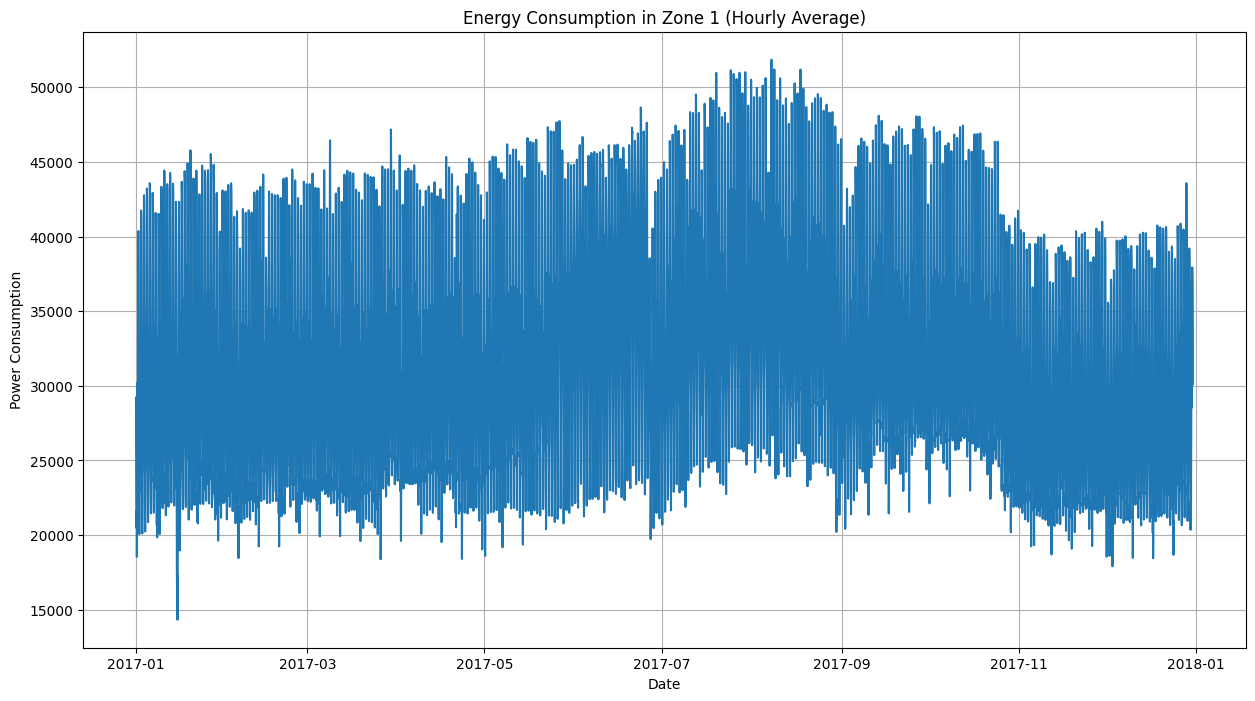

<ipython-input-5-dc8f263cd6c3>:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df['PowerConsumption_Zone2'].resample('1H').mean())


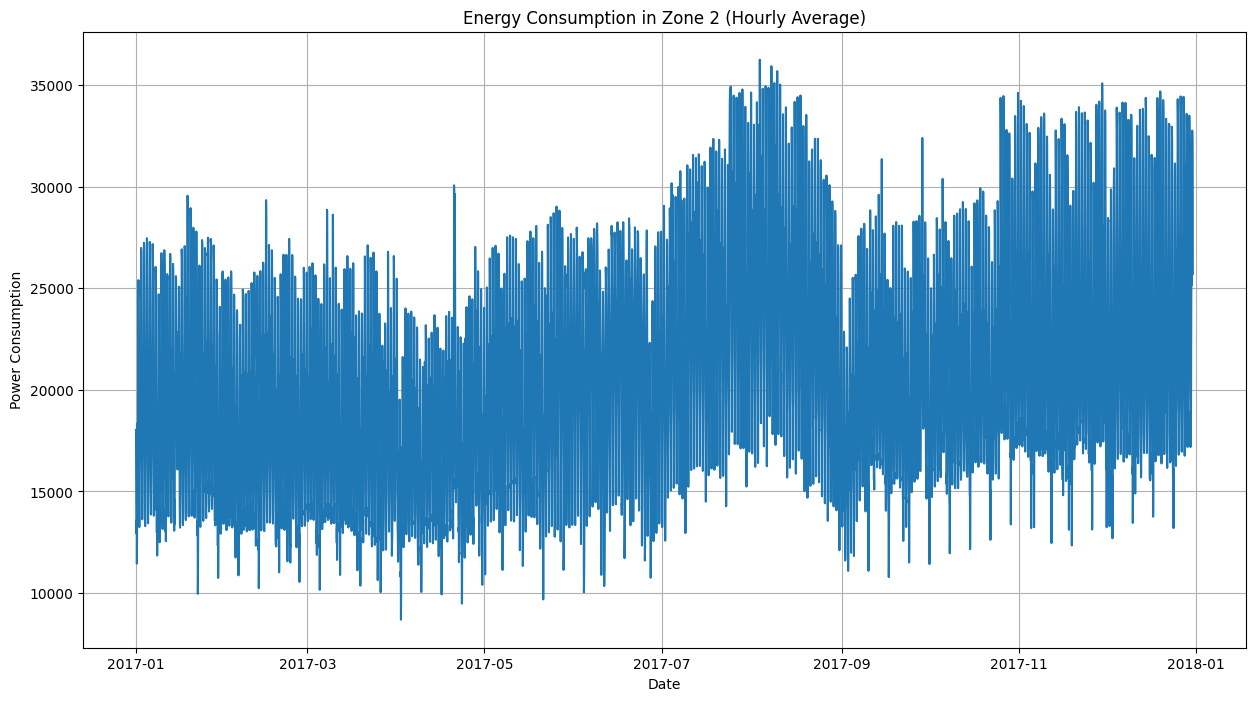

<ipython-input-5-dc8f263cd6c3>:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df['PowerConsumption_Zone3'].resample('1H').mean())


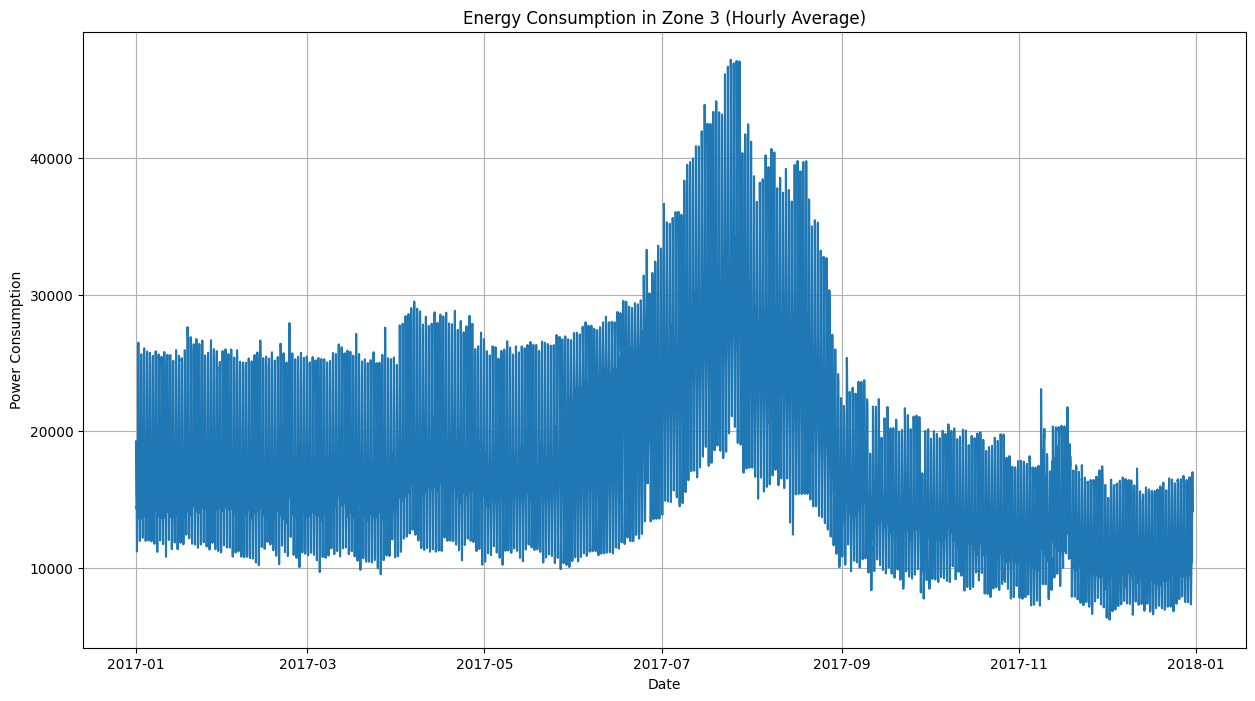

In [5]:
# 1.4 Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df['PowerConsumption_Zone1'].resample('1H').mean())
plt.title('Energy Consumption in Zone 1 (Hourly Average)')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df['PowerConsumption_Zone2'].resample('1H').mean())
plt.title('Energy Consumption in Zone 2 (Hourly Average)')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(df['PowerConsumption_Zone3'].resample('1H').mean())
plt.title('Energy Consumption in Zone 3 (Hourly Average)')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.grid(True)
plt.show()

<ipython-input-6-79e5393dd28c>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df['PowerConsumption_Zone1'].resample('1H').mean(), label='Zone 1')
<ipython-input-6-79e5393dd28c>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df['PowerConsumption_Zone2'].resample('1H').mean(), label='Zone 2')
<ipython-input-6-79e5393dd28c>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df['PowerConsumption_Zone3'].resample('1H').mean(), label='Zone 3')


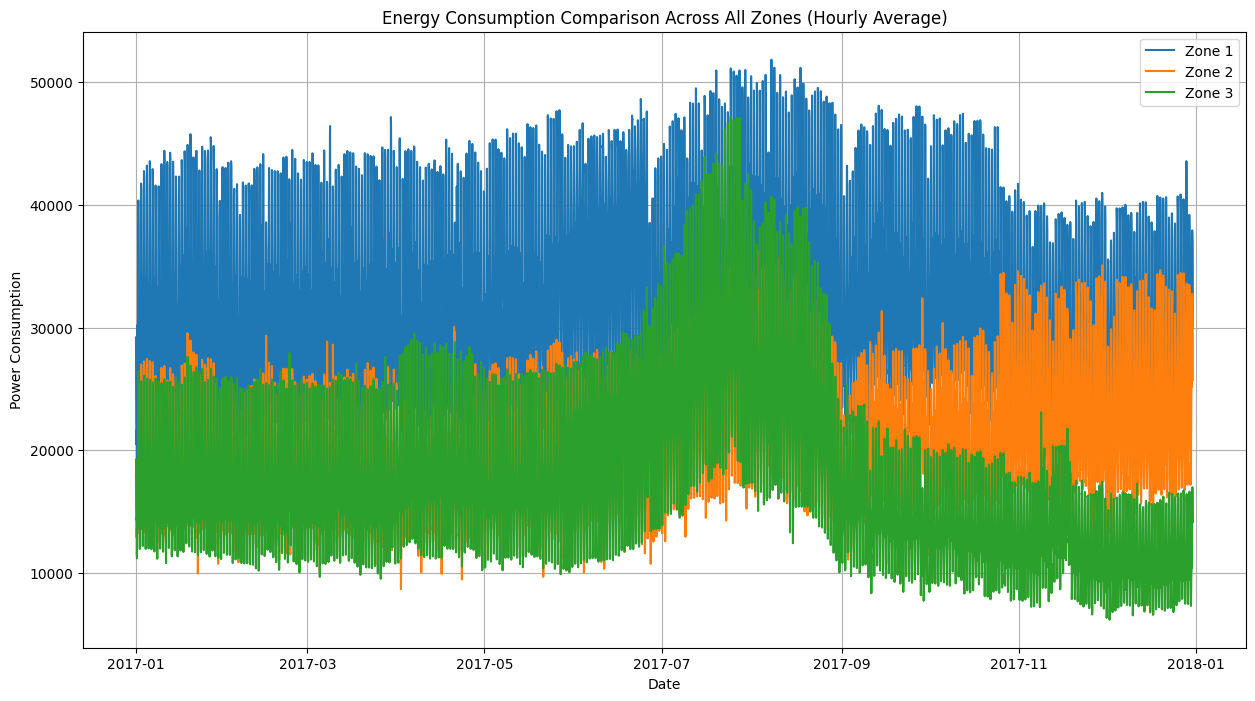

In [6]:
# Compare all zones on one plot
plt.figure(figsize=(15, 8))
plt.plot(df['PowerConsumption_Zone1'].resample('1H').mean(), label='Zone 1')
plt.plot(df['PowerConsumption_Zone2'].resample('1H').mean(), label='Zone 2')
plt.plot(df['PowerConsumption_Zone3'].resample('1H').mean(), label='Zone 3')
plt.title('Energy Consumption Comparison Across All Zones (Hourly Average)')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()


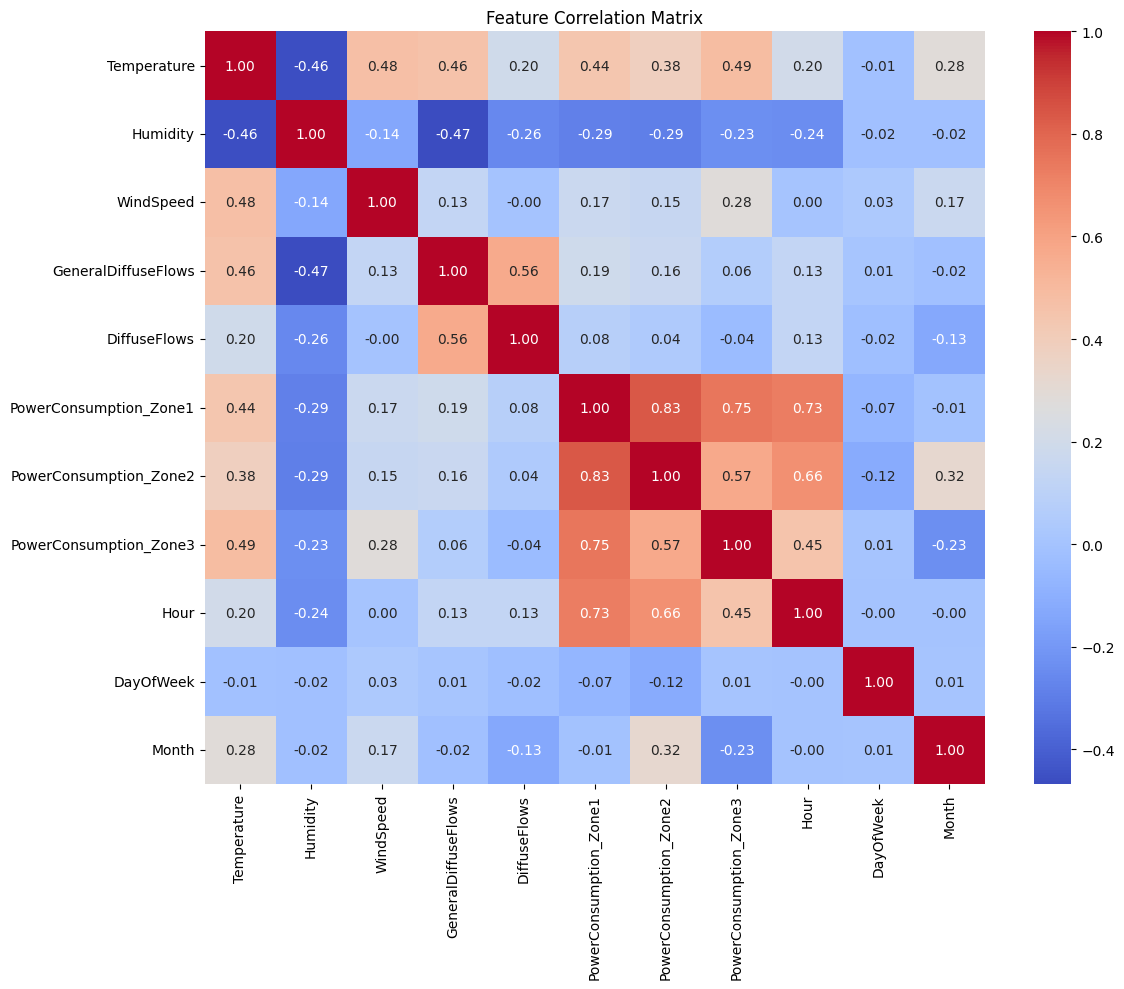


Hourly averaged data:
                     Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                      
2017-01-01 00:00:00     6.196833  75.066667   0.081833             0.063500   
2017-01-01 01:00:00     5.548833  77.583333   0.082000             0.056833   
2017-01-01 02:00:00     5.054333  78.933333   0.082333             0.063000   
2017-01-01 03:00:00     5.004333  77.083333   0.082833             0.059833   
2017-01-01 04:00:00     5.097667  74.050000   0.082333             0.058000   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 00:00:00      0.098833            29197.974683   
2017-01-01 01:00:00      0.112500            24657.215190   
2017-01-01 02:00:00      0.129167            22083.037973   
2017-01-01 03:00:00      0.141000            20811.139240   
2017-01-01 04:00:00      0.122833            20475.949367

<ipython-input-7-fa45b2529514>:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').mean()


In [7]:
# 1.5 Correlation Analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 1.6 Convert data to hourly averages
# For LSTM prediction, we might want hourly data instead of 10-minute data
df_hourly = df.resample('1H').mean()
print("\nHourly averaged data:")
print(df_hourly.head())

# We'll work with this hourly data for prediction
df = df_hourly

In [8]:
# 2. PREPARE DATA FOR LSTM MODEL
# 2.1 Define target variables and features

# Target variables (zones we want to predict)
target_cols = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']

# Feature columns (including time-based features we created)
feature_cols = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
                'DiffuseFlows', 'Hour', 'DayOfWeek', 'Month']


In [9]:
# 2.2 Data Normalization
# Normalize all features with MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit and transform feature columns
df_features_scaled = pd.DataFrame(
    scaler_features.fit_transform(df[feature_cols]),
    columns=feature_cols,
    index=df.index
)

# Fit and transform target columns
df_target_scaled = pd.DataFrame(
    scaler_target.fit_transform(df[target_cols]),
    columns=target_cols,
    index=df.index
)

print("\nScaled features:")
print(df_features_scaled.head())
print("\nScaled targets:")
print(df_target_scaled.head())


Scaled features:
                     Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                     
2017-01-01 00:00:00     0.071889  0.760076   0.004621             0.000047   
2017-01-01 01:00:00     0.053935  0.790752   0.004649             0.000040   
2017-01-01 02:00:00     0.040234  0.807208   0.004706             0.000046   
2017-01-01 03:00:00     0.038849  0.784658   0.004791             0.000043   
2017-01-01 04:00:00     0.041435  0.747684   0.004706             0.000041   

                     DiffuseFlows      Hour  DayOfWeek  Month  
Datetime                                                       
2017-01-01 00:00:00      0.000068  0.000000        1.0    0.0  
2017-01-01 01:00:00      0.000084  0.043478        1.0    0.0  
2017-01-01 02:00:00      0.000104  0.086957        1.0    0.0  
2017-01-01 03:00:00      0.000117  0.130435        1.0    0.0  
2017-01-01 04:00:00      0.000096  0.173913        

In [10]:
# 2.3 Create sequences for LSTM (time windows)
def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Define the number of time steps (hours we look back to predict the next hour)
# Since we're working with hourly data now, 6 time steps means 6 hours
TIME_STEPS = 6

# Convert dataframes to numpy arrays
features_array = df_features_scaled.values
target_array = df_target_scaled.values

# Create sequences
X, y = create_sequences(features_array, target_array, TIME_STEPS)

print("\nInput shape (X):", X.shape)
print("Output shape (y):", y.shape)


Input shape (X): (8730, 6, 8)
Output shape (y): (8730, 3)


In [11]:
# 2.4 Split data into training, validation, and test sets
# For time series data, we keep the chronological order
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("\nTraining set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (6111, 6, 8) (6111, 3)
Validation set shape: (1309, 6, 8) (1309, 3)
Testing set shape: (1310, 6, 8) (1310, 3)


In [12]:
# 3. BUILD AND TRAIN THE LSTM MODEL
# 3.1 Define the model architecture

# Get input dimensions
n_features = X_train.shape[2]  # Number of features
n_outputs = y_train.shape[1]   # Number of outputs (3 zones)

# Create the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(TIME_STEPS, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nModel Summary:")
model.summary()



Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 64)               │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,203 (121.89 KB)

 Trainable params: 31,203 (121.89 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 3.2 Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=0.0001
)

In [14]:
# 3.3 Train the model
history = model.fit(
    X_train, y_train,
    epochs=64,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=1
)

Epoch 1/64
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0748 - mae: 0.2078
Epoch 1: val_loss improved from inf to 0.02605, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0736 - mae: 0.2058 - val_loss: 0.0260 - val_mae: 0.1351 - learning_rate: 0.0010
Epoch 2/64
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - mae: 0.0952
Epoch 2: val_loss improved from 0.02605 to 0.01976, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0150 - mae: 0.0951 - val_loss: 0.0198 - val_mae: 0.1126 - learning_rate: 0.0010
Epoch 3/64
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - mae: 0.0806
Epoch 3: val_loss did not improve from 0.01976
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0110 - mae: 0.0806 - val_loss: 0.0239 - val_mae: 0.1234 - learning_rate: 0.0010
Epoch 4/64
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - mae: 0.0725
Epoch 4: val_loss improved from 0.01976 to 0.01928, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0091 - mae: 0.0725 - val_loss: 0.0193 - val_mae: 0.1139 - learning_rate: 0.0010
Epoch 5/64
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mae: 0.0701
Epoch 5: val_loss improved from 0.01928 to 0.01878, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0087 - mae: 0.0701 - val_loss: 0.0188 - val_mae: 0.1112 - learning_rate: 0.0010
Epoch 6/64
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0680
Epoch 6: val_loss did not improve from 0.01878
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0082 - mae: 0.0679 - val_loss: 0.0256 - val_mae: 0.1294 - learning_rate: 0.0010
Epoch 7/64
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0657
Epoch 7: val_loss did not improve from 0.01878
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - mae: 0.0657 - val_loss: 0.0248 - val_mae: 0.1278 - learning_rate: 0.0010
Epoch 8/64
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0626
Epoch 8: val_loss improved from 0.01878 to 0.01785, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0071 - mae: 0.0626 - val_loss: 0.0179 - val_mae: 0.1106 - learning_rate: 0.0010
Epoch 9/64
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0612
Epoch 9: val_loss improved from 0.01785 to 0.01493, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - mae: 0.0612 - val_loss: 0.0149 - val_mae: 0.1014 - learning_rate: 0.0010
Epoch 10/64
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mae: 0.0601
Epoch 10: val_loss did not improve from 0.01493
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - mae: 0.0601 - val_loss: 0.0183 - val_mae: 0.1110 - learning_rate: 0.0010
Epoch 11/64
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061 - mae: 0.0583
Epoch 11: val_loss improved from 0.01493 to 0.01270, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0061 - mae: 0.0583 - val_loss: 0.0127 - val_mae: 0.0930 - learning_rate: 0.0010
Epoch 12/64
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0583
Epoch 12: val_loss improved from 0.01270 to 0.01117, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0061 - mae: 0.0583 - val_loss: 0.0112 - val_mae: 0.0867 - learning_rate: 0.0010
Epoch 13/64
185/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mae: 0.0550
Epoch 13: val_loss improved from 0.01117 to 0.01090, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0056 - mae: 0.0550 - val_loss: 0.0109 - val_mae: 0.0860 - learning_rate: 0.0010
Epoch 14/64
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mae: 0.0573
Epoch 14: val_loss improved from 0.01090 to 0.00990, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - mae: 0.0572 - val_loss: 0.0099 - val_mae: 0.0806 - learning_rate: 0.0010
Epoch 15/64
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0534
Epoch 15: val_loss improved from 0.00990 to 0.00942, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0053 - mae: 0.0534 - val_loss: 0.0094 - val_mae: 0.0781 - learning_rate: 0.0010
Epoch 16/64
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - mae: 0.0548
Epoch 16: val_loss did not improve from 0.00942
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0055 - mae: 0.0548 - val_loss: 0.0104 - val_mae: 0.0776 - learning_rate: 0.0010
Epoch 17/64
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mae: 0.0520
Epoch 17: val_loss did not improve from 0.00942
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0049 - mae: 0.0520 - val_loss: 0.0106 - val_mae: 0.0774 - learning_rate: 0.0010
Epoch 18/64
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mae: 0.0512
Epoch 18: val_loss did not improve from 0.00942
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0049 - mae: 0.0512 - val_loss: 0.0157 - val_mae: 0.0915 - learning_rate: 0.0010
Epoch 19/64
187/191 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mae: 0.0503
E

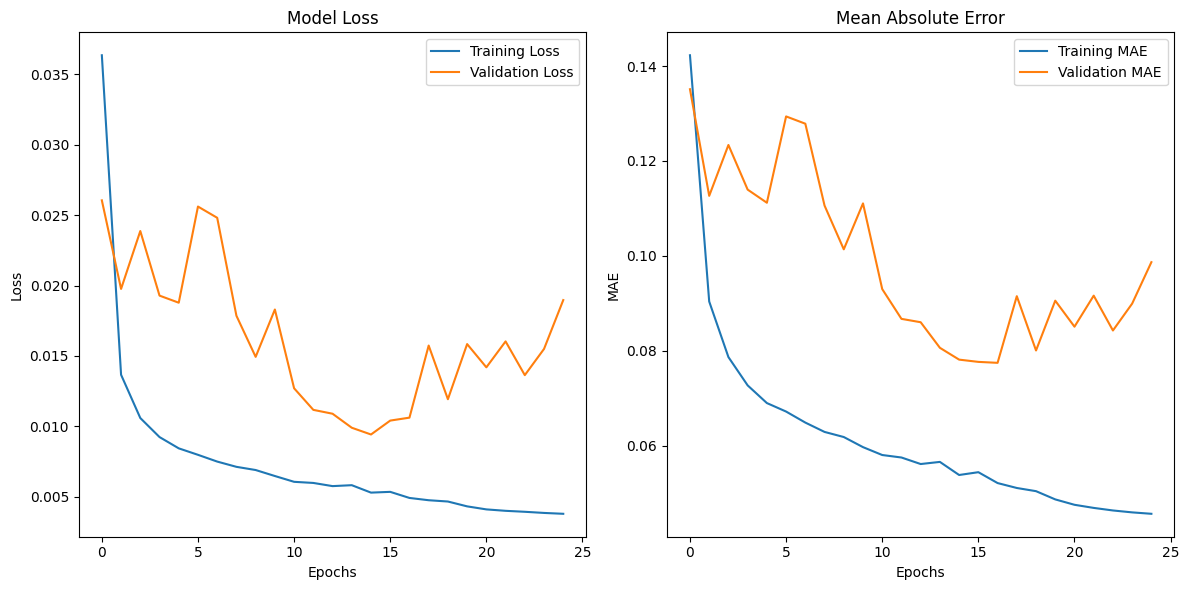

In [15]:
# 3.4 Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# 4. EVALUATE THE MODEL
# 4.1 Make predictions on the test set
y_pred = model.predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [17]:
# 4.2 Inverse transform the predictions and actual values back to original scale
y_test_inv = scaler_target.inverse_transform(y_test)
y_pred_inv = scaler_target.inverse_transform(y_pred)


In [18]:
# 4.3 Calculate performance metrics for each zone
zone_names = ['Zone 1', 'Zone 2', 'Zone 3']
metrics = pd.DataFrame(index=zone_names, columns=['R² Score', 'RMSE', 'MAE', 'MAPE'])

for i in range(n_outputs):
    # Calculate metrics
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test_inv[:, i] - y_pred_inv[:, i]) / y_test_inv[:, i])) * 100

    # Store metrics in DataFrame
    metrics.loc[zone_names[i]] = [r2, rmse, mae, mape]

print("\nPerformance Metrics:")
print(metrics)

# Also show metrics as percentage of mean consumption
mean_consumption = np.mean(y_test_inv, axis=0)
metrics['RMSE (%)'] = metrics['RMSE'] / mean_consumption * 100
metrics['MAE (%)'] = metrics['MAE'] / mean_consumption * 100

print("\nMetrics as percentage of mean consumption:")
print(metrics[['R² Score', 'RMSE (%)', 'MAE (%)', 'MAPE']])


Performance Metrics:
        R² Score         RMSE          MAE       MAPE
Zone 1  0.671899  3436.147973  2789.874565  10.530155
Zone 2 -0.115595    5853.2077  5031.366644  20.182531
Zone 3  0.395726  2589.296007  2183.631079  20.684655

Metrics as percentage of mean consumption:
        R² Score   RMSE (%)    MAE (%)       MAPE
Zone 1  0.671899  11.826848   9.602445  10.530155
Zone 2 -0.115595  24.893358  21.398115  20.182531
Zone 3  0.395726  21.674332  18.278615  20.684655


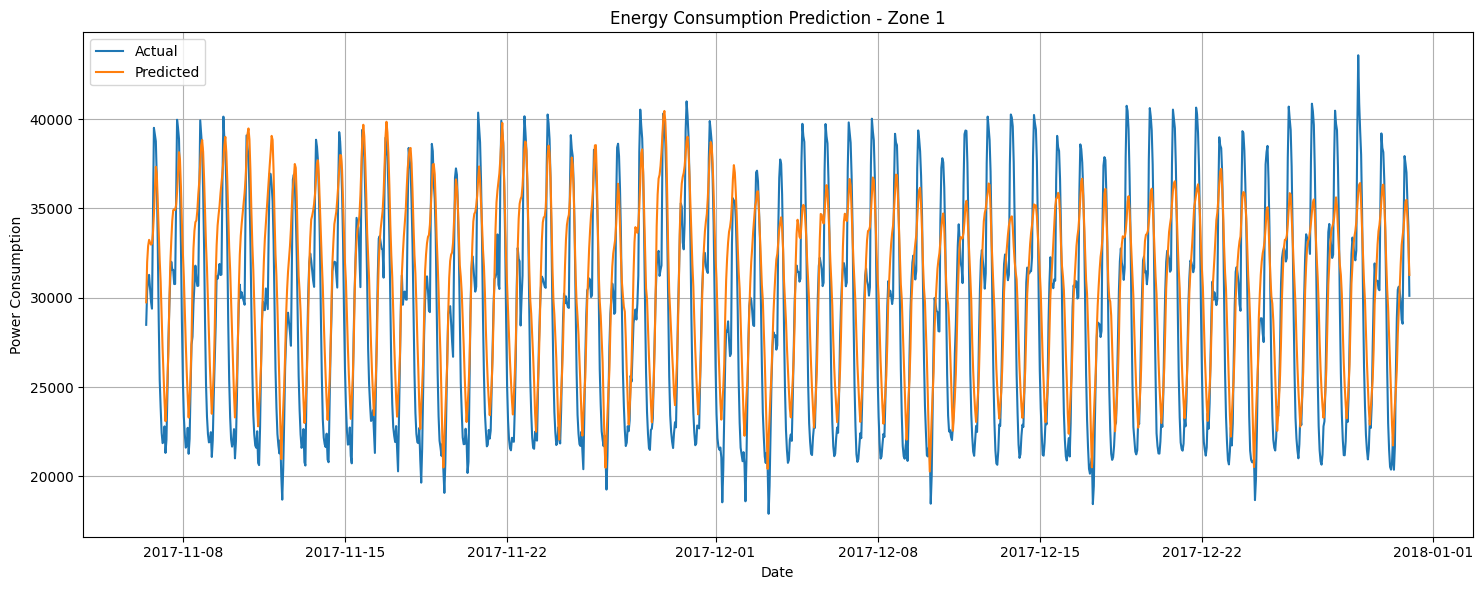

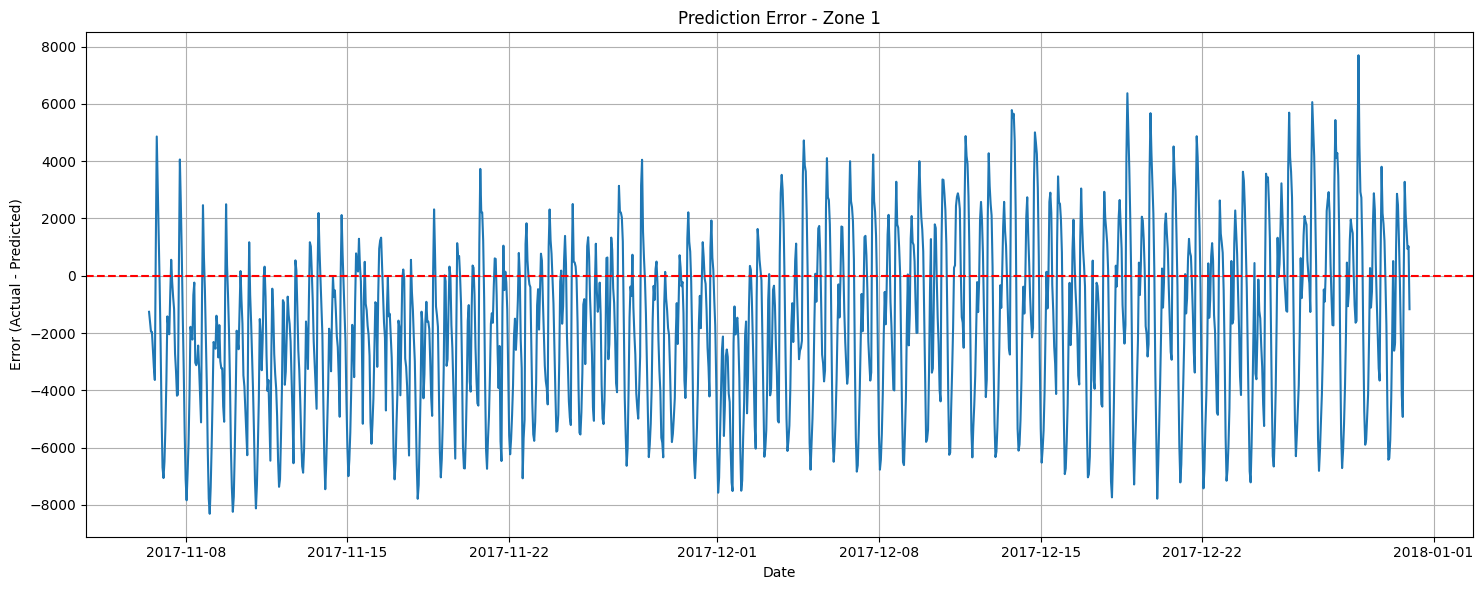

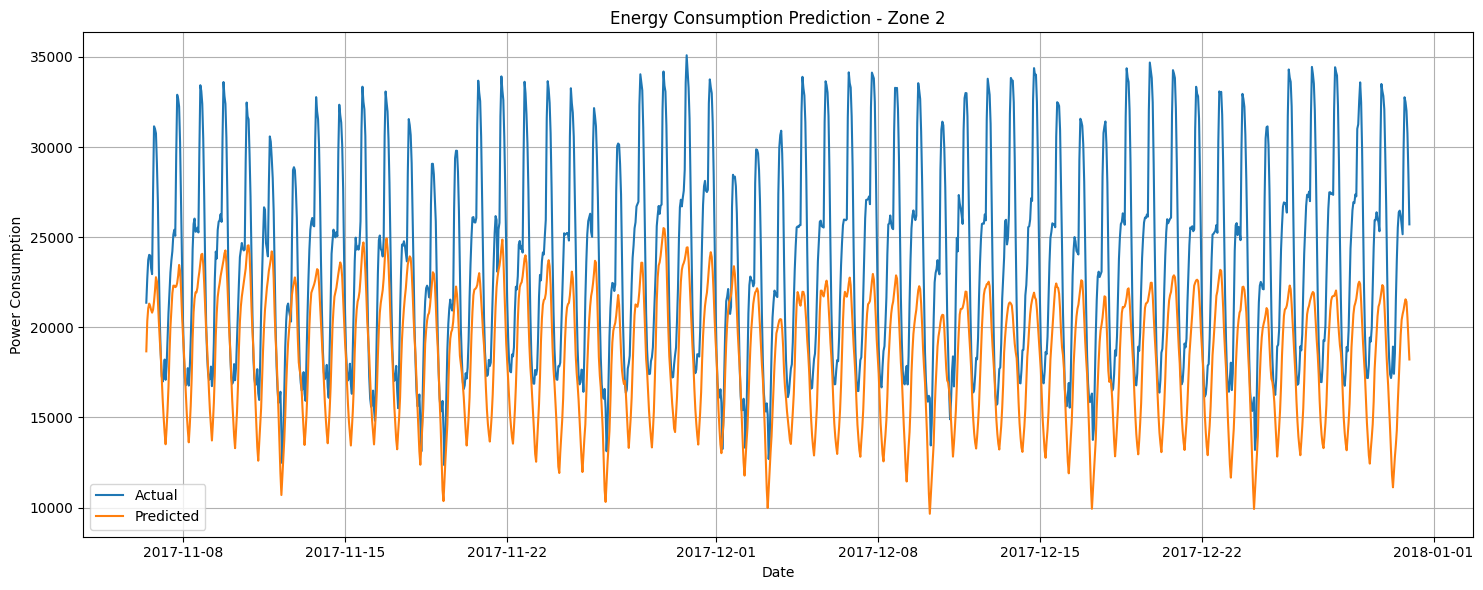

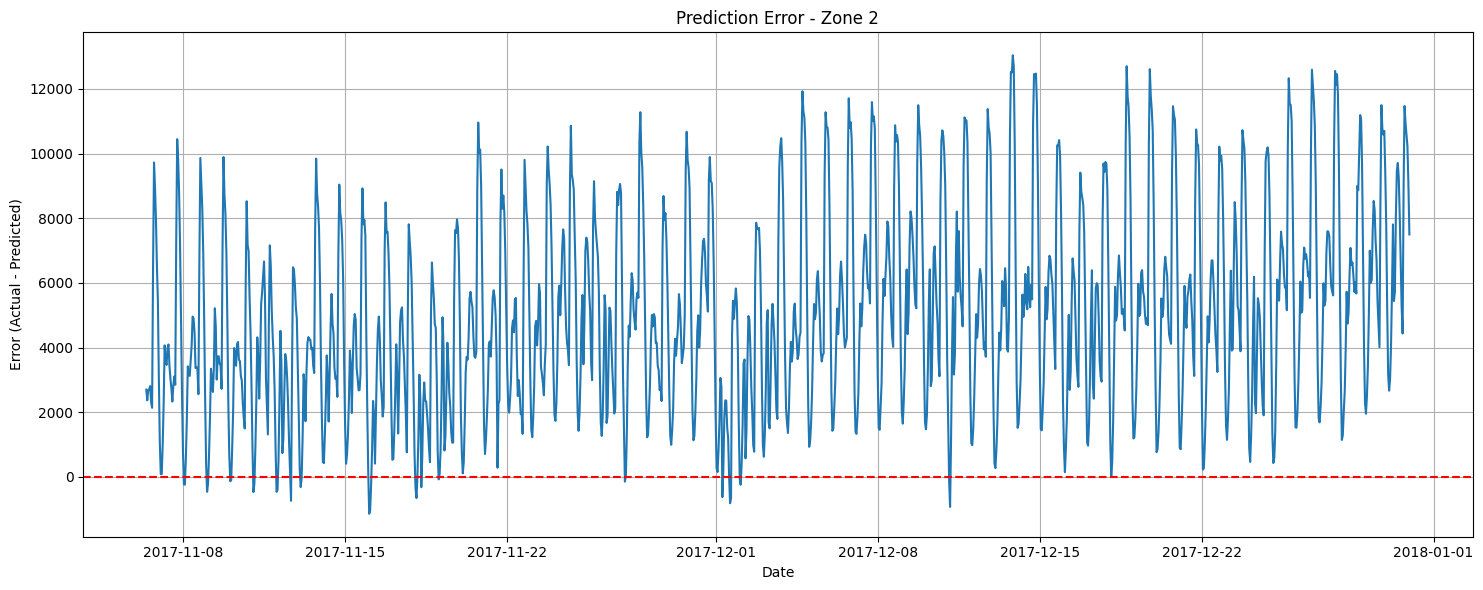

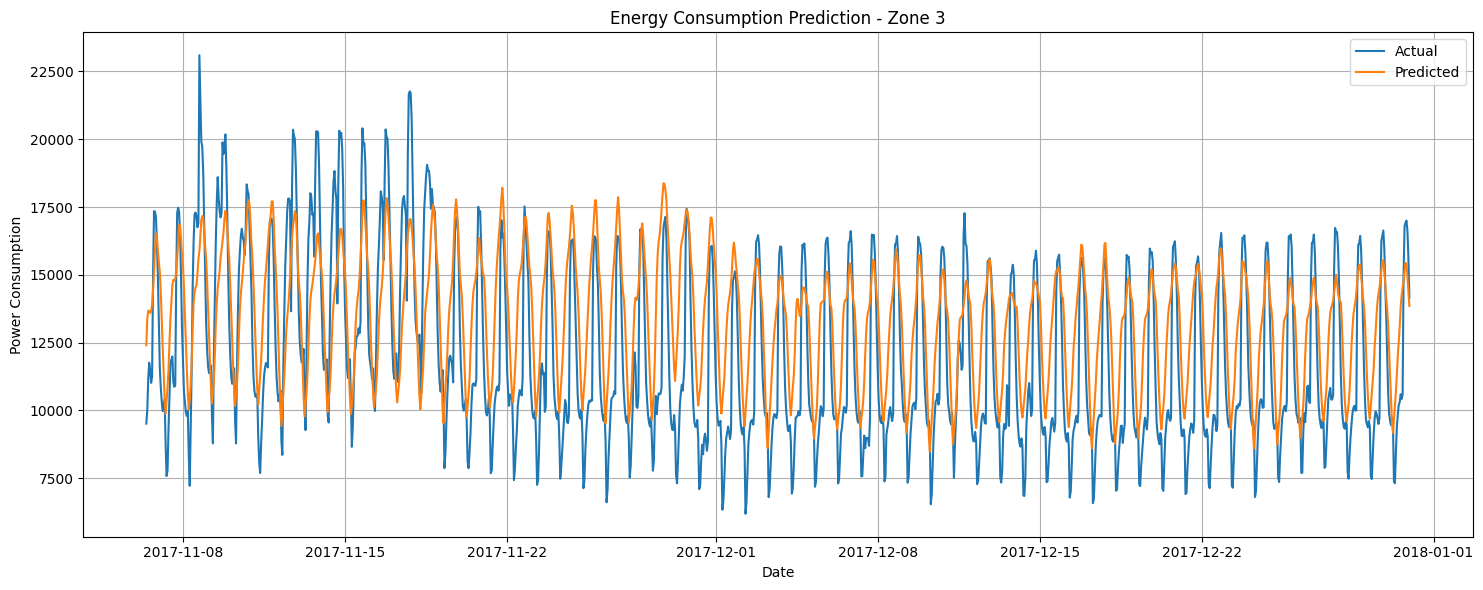

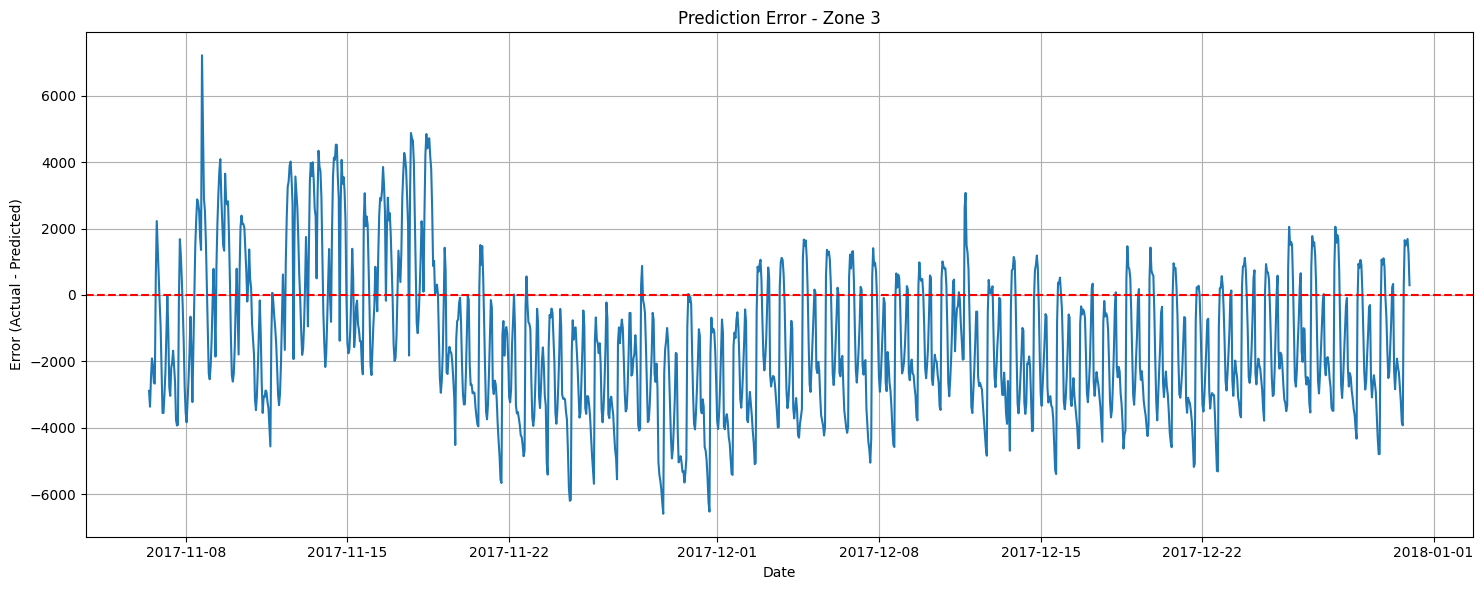

In [19]:
# 4.4 Visualize predictions vs actual values
# Get the timestamps for the test set
test_dates = df.index[train_size + val_size + TIME_STEPS:]

for i in range(n_outputs):
    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, y_test_inv[:, i], label='Actual')
    plt.plot(test_dates, y_pred_inv[:, i], label='Predicted')
    plt.title(f'Energy Consumption Prediction - {zone_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot residuals (errors)
    plt.figure(figsize=(15, 6))
    residuals = y_test_inv[:, i] - y_pred_inv[:, i]
    plt.plot(test_dates, residuals)
    plt.title(f'Prediction Error - {zone_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Error (Actual - Predicted)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
# 5. 3-DAY (72 HOURS) PREDICTION FOR ALL THREE ZONES
# 5.1 Function to predict multiple steps ahead
def predict_multiple_steps(model, initial_data, steps, scaler_features, scaler_target, time_steps, feature_cols, target_cols):
    """
    Make multi-step predictions for the next n steps for all three zones

    Parameters:
    - model: Trained LSTM model
    - initial_data: DataFrame containing the latest data (should have at least time_steps rows)
    - steps: Number of steps (hours) to predict into the future
    - scaler_features: Fitted MinMaxScaler for features
    - scaler_target: Fitted MinMaxScaler for targets
    - time_steps: Number of time steps used for prediction
    - feature_cols: List of feature column names
    - target_cols: List of target column names

    Returns:
    - DataFrame with predictions for all three zones over the specified time period
    """
    # Create a copy of the latest data to avoid modifying the original
    latest_data = initial_data.copy()

    # Create a DataFrame to store predictions
    future_dates = [latest_data.index[-1] + pd.Timedelta(hours=h+1) for h in range(steps)]
    predictions_df = pd.DataFrame(index=future_dates, columns=target_cols)

    # Get indices for time features
    hour_idx = feature_cols.index('Hour') if 'Hour' in feature_cols else None
    day_idx = feature_cols.index('DayOfWeek') if 'DayOfWeek' in feature_cols else None
    month_idx = feature_cols.index('Month') if 'Month' in feature_cols else None

    # Loop through each step
    for step in range(steps):
        # Get the latest window of data
        recent_data = latest_data[feature_cols].iloc[-time_steps:].values

        # Scale the features
        recent_data_scaled = scaler_features.transform(recent_data)

        # Reshape for LSTM input [samples, time steps, features]
        X_pred = recent_data_scaled.reshape(1, time_steps, len(feature_cols))

        # Make prediction
        y_pred_scaled = model.predict(X_pred, verbose=0)

        # Inverse transform to get actual values
        y_pred = scaler_target.inverse_transform(y_pred_scaled)[0]

        # Store prediction in DataFrame
        for i, col in enumerate(target_cols):
            predictions_df.iloc[step, i] = y_pred[i]

        # Create a new row with the predicted values and estimated features
        next_datetime = latest_data.index[-1] + pd.Timedelta(hours=1)
        next_row = pd.DataFrame(index=[next_datetime], columns=latest_data.columns)

        # Copy the last row's feature values as a starting point
        next_row.iloc[0] = latest_data.iloc[-1]

        # Update time-based features
        if hour_idx is not None:
            next_row.iloc[0, hour_idx] = next_datetime.hour
        if day_idx is not None:
            next_row.iloc[0, day_idx] = next_datetime.dayofweek
        if month_idx is not None:
            next_row.iloc[0, month_idx] = next_datetime.month

        # Update target values with predictions
        for i, col in enumerate(target_cols):
            next_row[col] = y_pred[i]

        # Append this new row to our latest_data for the next prediction step
        latest_data = pd.concat([latest_data, next_row])

    return predictions_df



In [21]:
# 5.2 Get the last available data
last_available_data = df.iloc[-(TIME_STEPS+1):]

# 5.3 Predict the next 72 hours (3 days)
prediction_steps = 72
predictions_df = predict_multiple_steps(
    model,
    last_available_data,
    prediction_steps,
    scaler_features,
    scaler_target,
    TIME_STEPS,
    feature_cols,
    target_cols
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida


--- 3-Day Energy Consumption Forecast ---
Forecast start: 2017-12-31 00:00:00
Forecast end: 2018-01-02 23:00:00

Summary Statistics:
        PowerConsumption_Zone1  PowerConsumption_Zone2  PowerConsumption_Zone3
count                72.000000               72.000000               72.000000
unique                6.000000                6.000000                6.000000
top               28057.472656            15661.370117            13414.416016
freq                 67.000000               67.000000               67.000000


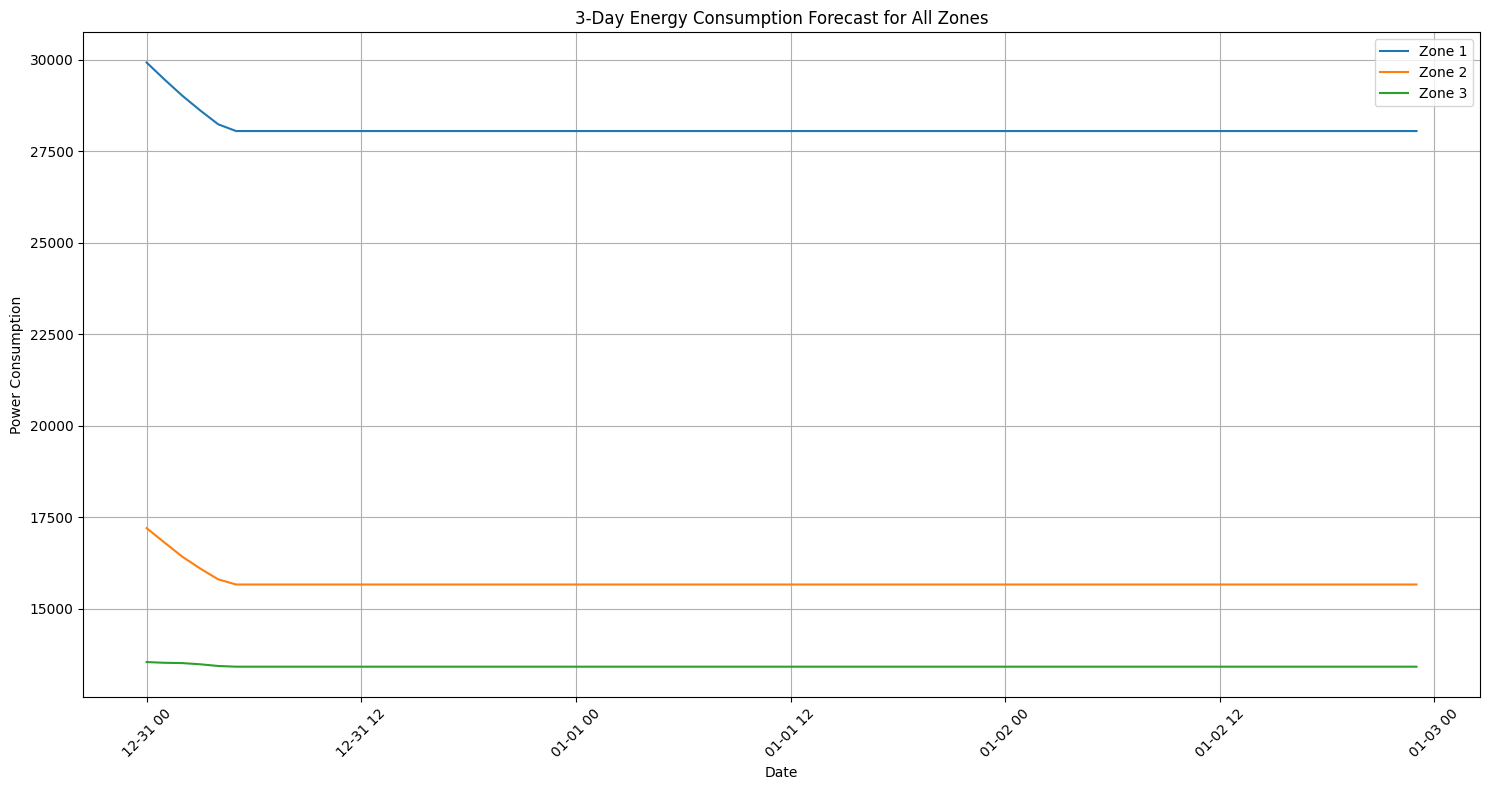

In [22]:
# 5.4 Print prediction summary
print("\n--- 3-Day Energy Consumption Forecast ---")
print("Forecast start:", predictions_df.index[0])
print("Forecast end:", predictions_df.index[-1])
print("\nSummary Statistics:")
print(predictions_df.describe())

# 5.5 Visualize predictions for each zone
plt.figure(figsize=(15, 8))
for i, col in enumerate(target_cols):
    plt.plot(predictions_df.index, predictions_df[col], label=f'{zone_names[i]}')

plt.title('3-Day Energy Consumption Forecast for All Zones')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


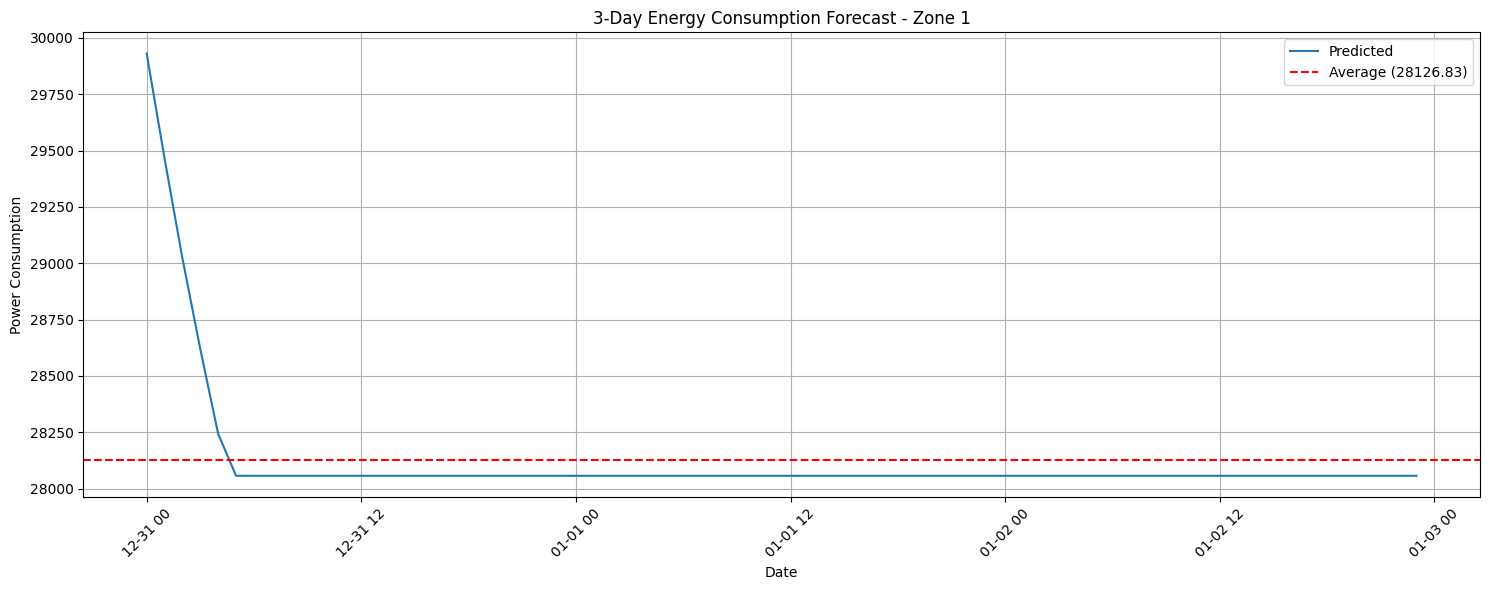

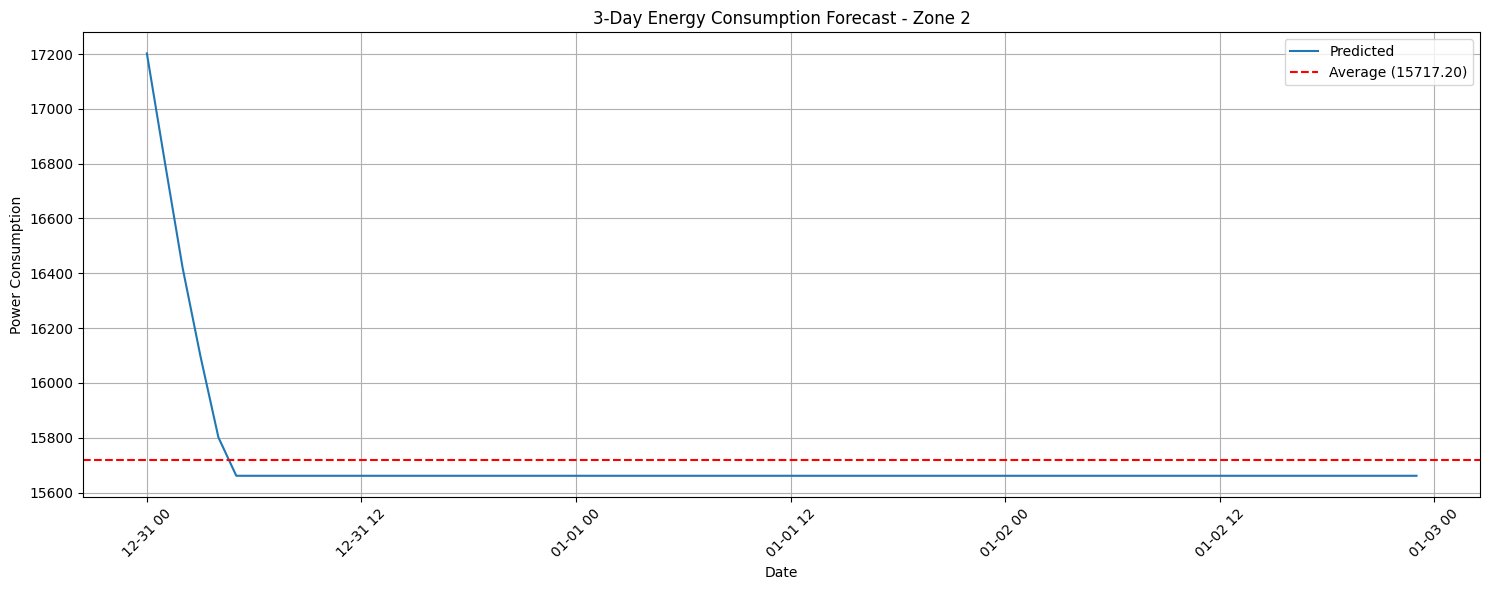

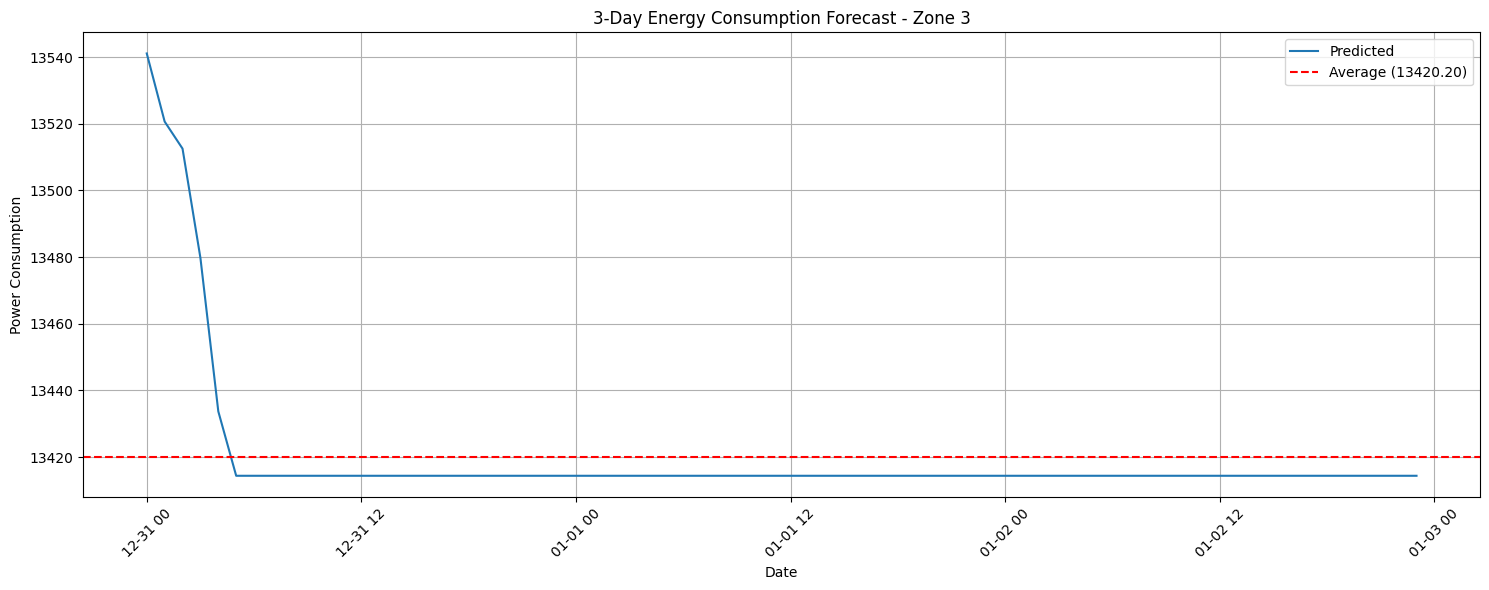

In [23]:
# 5.6 Visualize each zone separately
for i, col in enumerate(target_cols):
    plt.figure(figsize=(15, 6))
    plt.plot(predictions_df.index, predictions_df[col], label=f'Predicted')

    # Add average line
    avg = predictions_df[col].mean()
    plt.axhline(y=avg, color='r', linestyle='--', label=f'Average ({avg:.2f})')

    plt.title(f'3-Day Energy Consumption Forecast - {zone_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


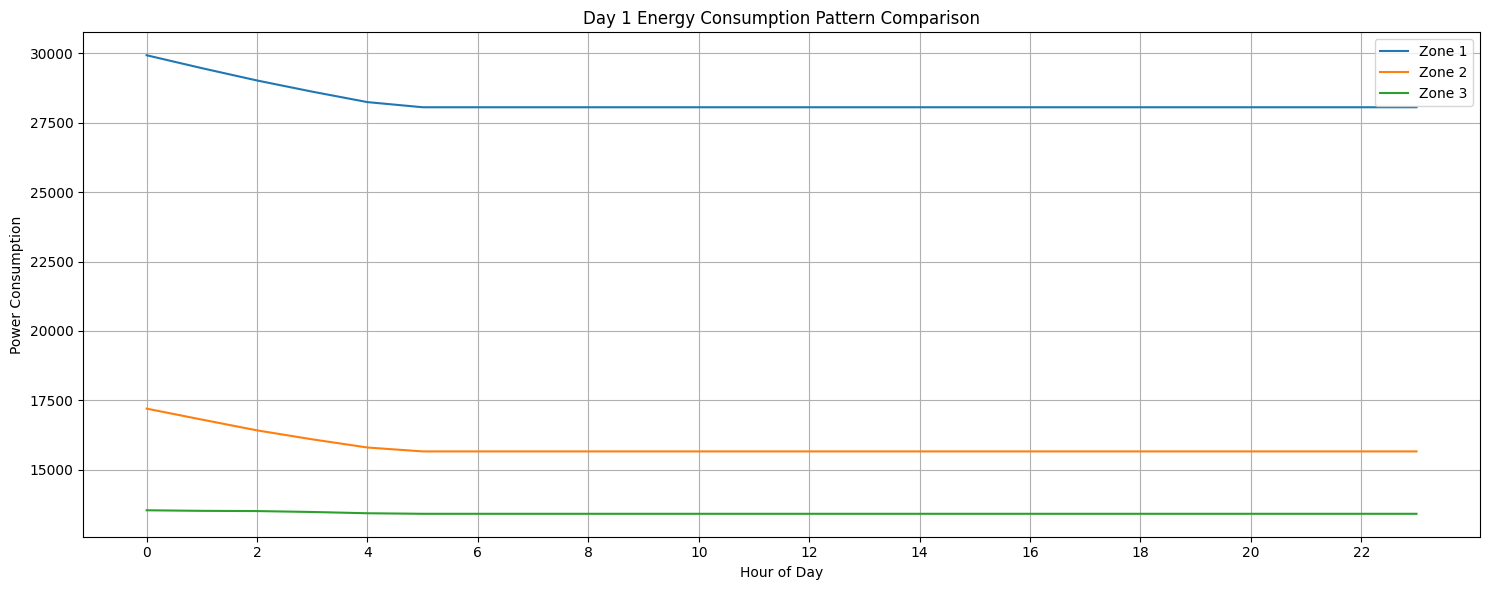

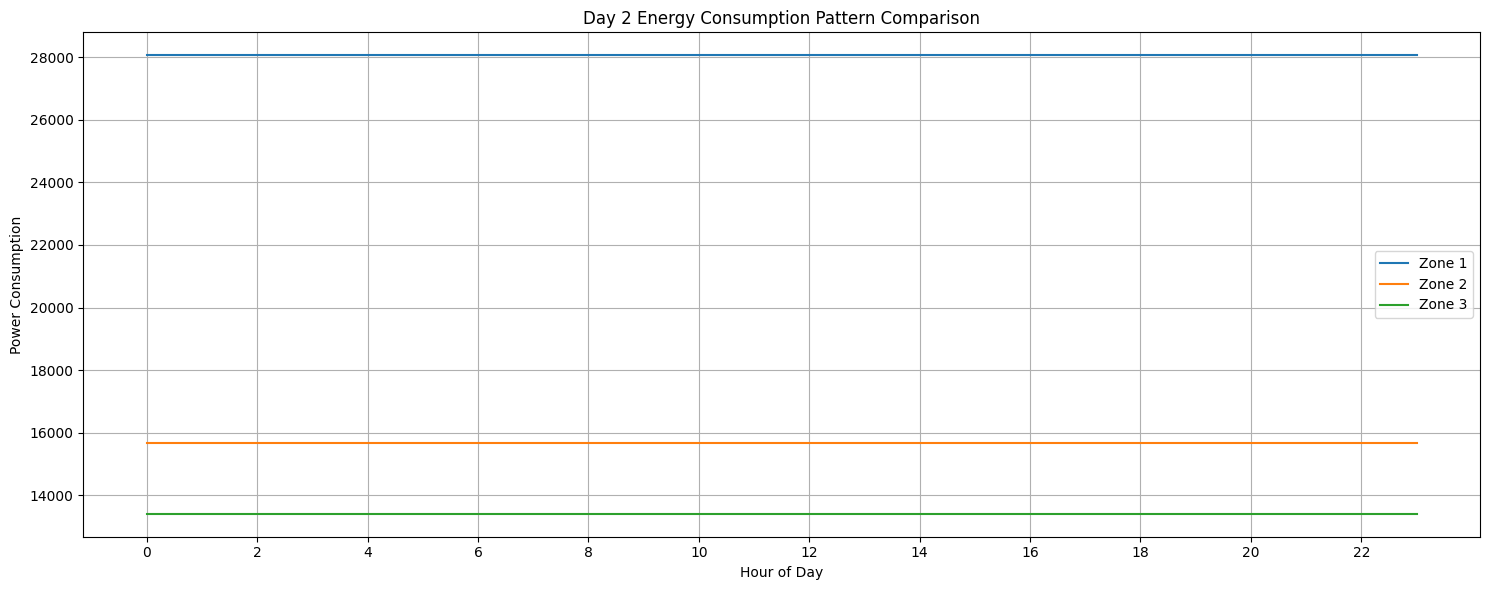

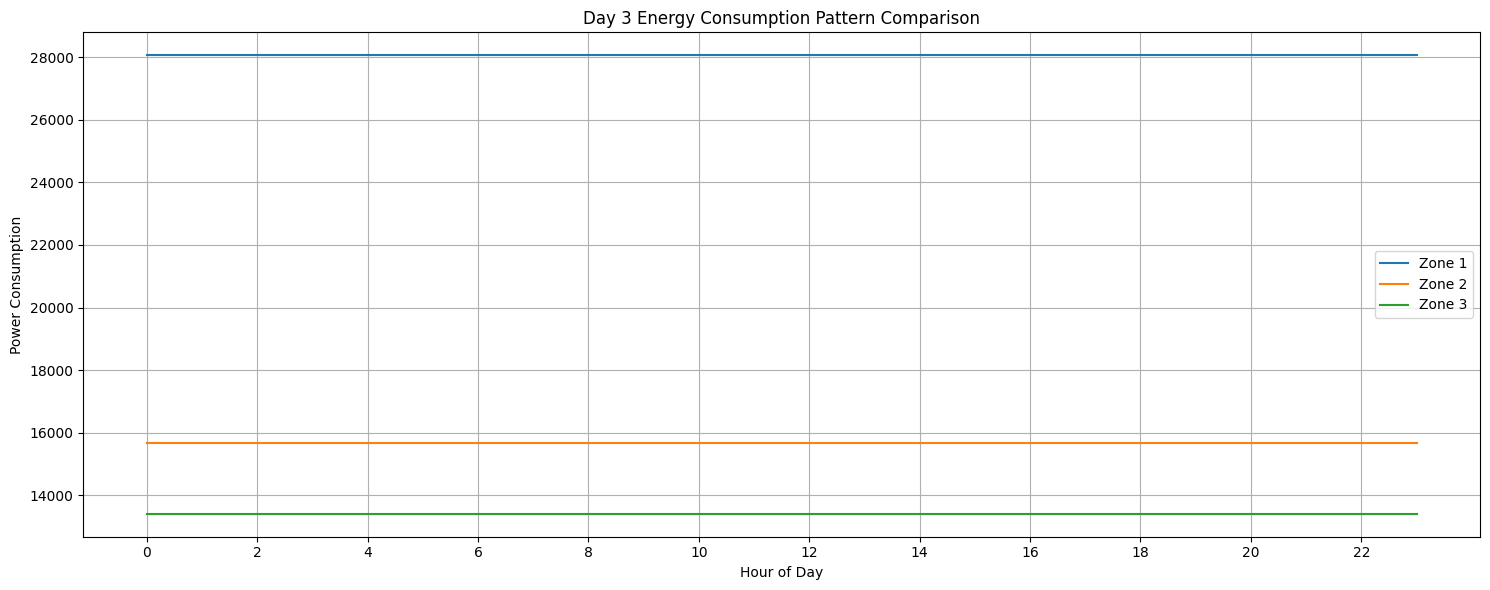

In [24]:
# 5.7 Compare daily patterns across zones
# Reshape data to highlight daily patterns
daily_patterns = predictions_df.copy()
daily_patterns['Hour'] = daily_patterns.index.hour
daily_patterns['Day'] = [(idx - predictions_df.index[0]).days + 1 for idx in daily_patterns.index]

# Plot daily patterns for each predicted day
for day in range(1, 4):  # 3 days
    day_data = daily_patterns[daily_patterns['Day'] == day]

    plt.figure(figsize=(15, 6))
    for i, col in enumerate(target_cols):
        plt.plot(day_data['Hour'], day_data[col], label=f'{zone_names[i]}')

    plt.title(f'Day {day} Energy Consumption Pattern Comparison')
    plt.xlabel('Hour of Day')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24, 2))
    plt.tight_layout()
    plt.show()

In [25]:
# 5.8 Compare zones statistically
print("\n--- Statistical Comparison Between Zones (3-Day Forecast) ---")
zone_stats = predictions_df.describe().T
zone_stats['Range'] = zone_stats['max'] - zone_stats['min']
zone_stats['Coefficient of Variation'] = zone_stats['std'] / zone_stats['mean'] * 100
print(zone_stats[['mean', 'std', 'min', 'max', 'Range', 'Coefficient of Variation']])

# 5.9 Calculate daily consumption totals
daily_consumption = {}
for day in range(1, 4):  # 3 days
    day_data = daily_patterns[daily_patterns['Day'] == day]
    day_totals = day_data[target_cols].sum()
    daily_consumption[f'Day {day}'] = day_totals

daily_consumption_df = pd.DataFrame(daily_consumption).T
print("\n--- Daily Consumption Totals ---")
print(daily_consumption_df)

# Visualize daily consumption totals
plt.figure(figsize=(12, 6))
daily_consumption_df.plot(kind='bar')
plt.title('Total Daily Energy Consumption Forecast by Zone')
plt.xlabel('Day')
plt.ylabel('Total Power Consumption')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


--- Statistical Comparison Between Zones (3-Day Forecast) ---


KeyError: 'max'

In [ ]:
# 6. FEATURE IMPORTANCE ANALYSIS
# 6.1 Create a function for calculating feature importance
def calculate_feature_importance(model, X, feature_names):
    # Create a baseline prediction
    baseline_prediction = model.predict(X)

    # Calculate importance for each feature
    importances = []

    for i in range(X.shape[2]):  # For each feature
        # Create a copy of the input data
        X_modified = X.copy()

        # Shuffle the values of the current feature
        np.random.shuffle(X_modified[:, :, i])

        # Make predictions with the modified data
        new_prediction = model.predict(X_modified)

        # Calculate the mean absolute difference in predictions
        importance = np.mean(np.abs(baseline_prediction - new_prediction))
        importances.append(importance)

    # Normalize importances
    importances = np.array(importances) / np.sum(importances)

    # Create DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    return importance_df.sort_values('Importance', ascending=False)

# Calculate feature importance
feature_importance = calculate_feature_importance(model, X_test, feature_cols)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Energy Consumption Prediction')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)


In [ ]:
# 7. SAVE THE MODEL AND SCALERS FOR FUTURE USE
from tensorflow.keras.models import load_model
import joblib

# Save the model
model.save('lstm_energy_prediction_model.h5')

# Save the scalers
joblib.dump(scaler_features, 'feature_scaler.pkl')
joblib.dump(scaler_target, 'target_scaler.pkl')

# Save the 3-day predictions to CSV
predictions_df.to_csv('three_day_energy_forecast.csv')

print("\nModel, scalers, and 3-day forecast saved successfully.")
print("You can load them later using:")
print("model = load_model('lstm_energy_prediction_model.h5')")
print("scaler_features = joblib.load('feature_scaler.pkl')")
print("scaler_target = joblib.load('target_scaler.pkl')")
print("forecast = pd.read_csv('three_day_energy_forecast.csv', index_col=0, parse_dates=True)")


In [ ]:
# 8. NOTES FOR EMS INTEGRATION
"""
To integrate this model into an Energy Management System:

1. Data Pipeline:
   - Set up a data collection system that gathers sensor data every 10 minutes
   - Process and aggregate this data hourly for prediction
   - Ensure datetime formatting matches the training data

2. Prediction System:
   - Load the saved model and scalers
   - Use the predict_multiple_steps() function for 3-day forecasts
   - Set up a scheduler to update predictions at regular intervals (e.g., every 6 hours)

3. Alert System:
   - Define thresholds for energy consumption
   - Compare predictions with thresholds
   - Send alerts if predictions exceed thresholds
   - Create alerts for unusual patterns across different zones

4. Dashboard:
   - Create a visualization dashboard showing:
     - Current consumption
     - 3-day forecast
     - Zone comparisons
     - Daily patterns
     - Historical data
     - Prediction accuracy

5. Optimization:
   - Based on predictions, suggest optimal operation times
   - Identify patterns of high consumption
   - Recommend energy-saving measures
   - Compare efficiencies between zones

6. Retraining:
   - Set up a system to periodically retrain the model with new data
   - Monitor model performance and retrain if accuracy drops below threshold
"""

print("\nRefer to the notes section in the code for guidance on EMS integration.")